In [ ]:
%cd ..

In [1]:
import typing
from pathlib import Path

from datasets import load_dataset, Audio
import gigaam
from gigaam.model import GigaAMASR
import soundfile as sf
from tqdm.auto import tqdm

from asr_eval.models.gigaam import encode
from asr_eval.streaming.timings import get_word_timings
from asr_eval.utils import utterances_to_srt

In [2]:
model = typing.cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))

In [ ]:
# type: ignore

datasets = {
    'podlodka': (
        load_dataset('bond005/podlodka_speech')['test']
        .cast_column("audio", Audio(sampling_rate=16_000))
        .take(20)
    ),
    'golos_farfield': (
        load_dataset('bond005/sberdevices_golos_100h_farfield')['test']
        .cast_column("audio", Audio(sampling_rate=16_000))
        .take(20)
    ),
}

for dataset_name, dataset in datasets.items():
    dir = Path(f'srt/{dataset_name}')
    dir.mkdir(exist_ok=True, parents=True)
    for sample_idx, sample in tqdm(enumerate(dataset)):
        waveform = sample['audio']['array']
        text = sample['transcription']
        text = text.lower().replace('ё', 'е').replace('-', ' ')
        for char in ('.', ',', '!', '?', ';', ':', '"', '(', ')'):
            text = text.replace(char, '')
        try:
            encode(model, text)
        except ValueError:
            print(f'Cannot encode: {text}')
            continue
        timings = get_word_timings(model, waveform, text)
        (dir / f'{sample_idx}.srt').write_text(utterances_to_srt(timings))
        sf.write(dir / f'{sample_idx}.wav', waveform, samplerate=16_000)
        break

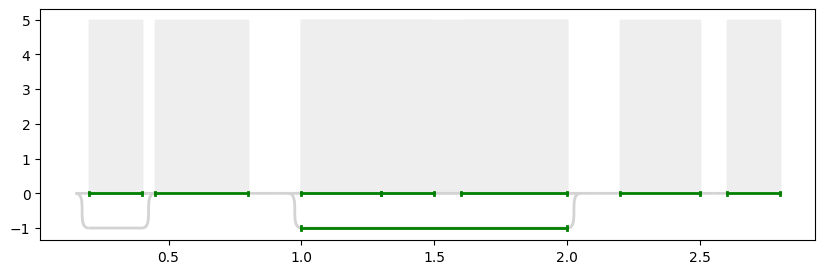

In [3]:
import matplotlib.pyplot as plt

from asr_eval.align.data import Anything, Token, MultiVariant


transcription: list[Token | MultiVariant] = [
    MultiVariant([
        [Token('ну', start_time=0.2, end_time=0.4)],
        [],
    ]),
    Token('в', start_time=0.45, end_time=0.8),
    MultiVariant([
        [
            Token('девятьсот', start_time=1.0, end_time=1.3),
            Token('пятьдесят', start_time=1.3, end_time=1.5),
            Token('четвертом', start_time=1.6, end_time=2.0),
        ],
        [Token('954', start_time=1.0, end_time=2.0)],
    ]),
    Token(Anything(), start_time=2.2, end_time=2.5),
    Token('году', start_time=2.6, end_time=2.8),
]

from asr_eval.plots import draw_transcription

plt.figure(figsize=(10, 3)) # type: ignore
draw_transcription(transcription, graybox_y=(0, 5))
plt.show() # type: ignore